In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# required due to an issue with CUDA on Windows (https://github.com/pytorch/pytorch/issues/17108)
torch.cuda.current_device()

# for loading MNIST data
from torchvision import transforms, datasets

In [2]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# if cuda device is available then run model on gpu
if torch.cuda.is_available():
    cuda_flag=True
else:
    cuda_flag=False

### Setting up data loader

Data loaders make our lives easier by providing an easy interface to access data in batches as well shuffle the data so that no bias due to grouping of examples creep in.

Using torchvision's datasets module we can directly download MNIST dataset and transform it to give us images in the form of Tensors.

In [5]:
batch_size=64

train_loader = torch.utils.data.DataLoader(datasets.MNIST('./dataset/', train=True, download=True,
                             transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('./dataset/', train=False, download=True,
                             transform=transforms.ToTensor()), batch_size=batch_size)

### Class Definition for the Model

We define a simple (yet good enough for our small problem) architecture of two convolutional layers followed by two fully connected layers and use ReLU activation. We also add max pooling in between convolutional layers. Lastly we return a softmax of output vector.

In [6]:
class clf_mnist(nn.Module):
    def __init__(self, num_classes):
        super(clf_mnist, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32*7*7,256)
        self.fc2 = nn.Linear(256,num_classes)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self,x):
        # 1*28*28 -> 16*14*14
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        
        # 16*14*14 -> 32*7*7
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(-1,32*7*7)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x),1)
        return x

### Training phase

In [22]:
# instantiate the model
model = clf_mnist(10)
if cuda_flag:
    model = model.cuda()

In [23]:
# define optimizer to update the model parameters
opt = optim.Adam(model.parameters())

# define loss function
crit = nn.CrossEntropyLoss()

In [24]:
epochs = 5
loss_history = []

In [25]:
for epoch in tqdm(range(epochs)):
    train_loss=0
    accuracy = 0
    
    # iterate over dataset
    for x,y in train_loader:
        
        # zero_grad to ensure no unaccounted calculation creeps in while calculating gradients
        opt.zero_grad()
        
        # move data to gpu if cuda_flag is set
        if cuda_flag:
            x,y = x.cuda(), y.cuda()
        
        # forward propogation and loss computation
        y_pred = model(x)
        loss = crit(y_pred,y)
        train_loss+=loss.item()
        
        # backpropogate gradients
        loss.backward()
        
        # update weights
        opt.step()

        # find class with maximum probability for each example and calculate accuracy
        _, predicted = torch.max(y_pred, 1)
        accuracy += (predicted == y).sum().item()
    
    accuracy = accuracy*100/(batch_size*len(train_loader))
    print ("Epoch:{} Train Loss:{:.3} Train Accuracy:{:.2}".format(epoch,train_loss,accuracy))
    loss_history.append(train_loss)

Epoch:0 Train Loss:1.46e+03 Train Accuracy:0.91
Epoch:1 Train Loss:1.4e+03 Train Accuracy:0.97
Epoch:2 Train Loss:1.39e+03 Train Accuracy:0.98
Epoch:3 Train Loss:1.39e+03 Train Accuracy:0.98
Epoch:4 Train Loss:1.38e+03 Train Accuracy:0.99


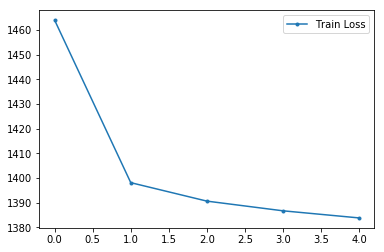

In [26]:
# Plot loss function to see how the training proceeded, useful while debugging models
plt.plot(loss_history, ".-", label="Train Loss")
plt.legend()

### Testing Phase

In [27]:
accuracy = 0

for x,y in tqdm(test_loader):
    if cuda_flag:
        x,y = x.cuda(), y.cuda()
    _, predicted = torch.max(model(x).detach(), 1) # detach to avoid accidental gradient packpropogation
    correct = (predicted == y).sum()
    accuracy += correct.item() 
    
print ("Test Accuracy:",accuracy/(len(test_loader)*64))

Test Accuracy: 0.9814888535031847


#### Visualising the classification performance